In [1]:
import os
import torch,torchvision
import matplotlib
from PIL import Image
from torchvision import transforms
from torch import nn
import numpy as np
import segmentation_models_pytorch as smp
import cv2
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import glob
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
G = torch.load('G_pix2pix_BF2Cy5').module
G = G.to(device)

mean_BF = torch.tensor([2355.3508])
std_BF = torch.tensor([353.2483])
mean_label = torch.tensor([2185.792])
std_label = torch.tensor([2148.2190])
pre_transform = transforms.ToTensor()

post_transform_image = transforms.Compose([
                                           transforms.Resize(size=(600, 600)),
                                           transforms.CenterCrop(512),
                                           transforms.Normalize(mean_BF,std_BF)
                                          ])
post_transform_label = transforms.Compose([
                                           transforms.Resize(size=(600, 600)),
                                           transforms.CenterCrop(512),
                                           transforms.Normalize(mean_label,std_label)])
to_image = transforms.ToPILImage()
inv_normalize_BF = transforms.Normalize(
    mean=-mean_BF/std_BF,
    std=1/std_BF
)
inv_normalize_label = transforms.Normalize(
    mean=-mean_label/std_label,
    std = 1/std_label
)

In [23]:
x = pre_transform(Image.open('sample2_bf.tif')).float()
y = pre_transform(Image.open('sample2_cy5.tif')).float()

x = post_transform_image(x)
y = post_transform_label(y)

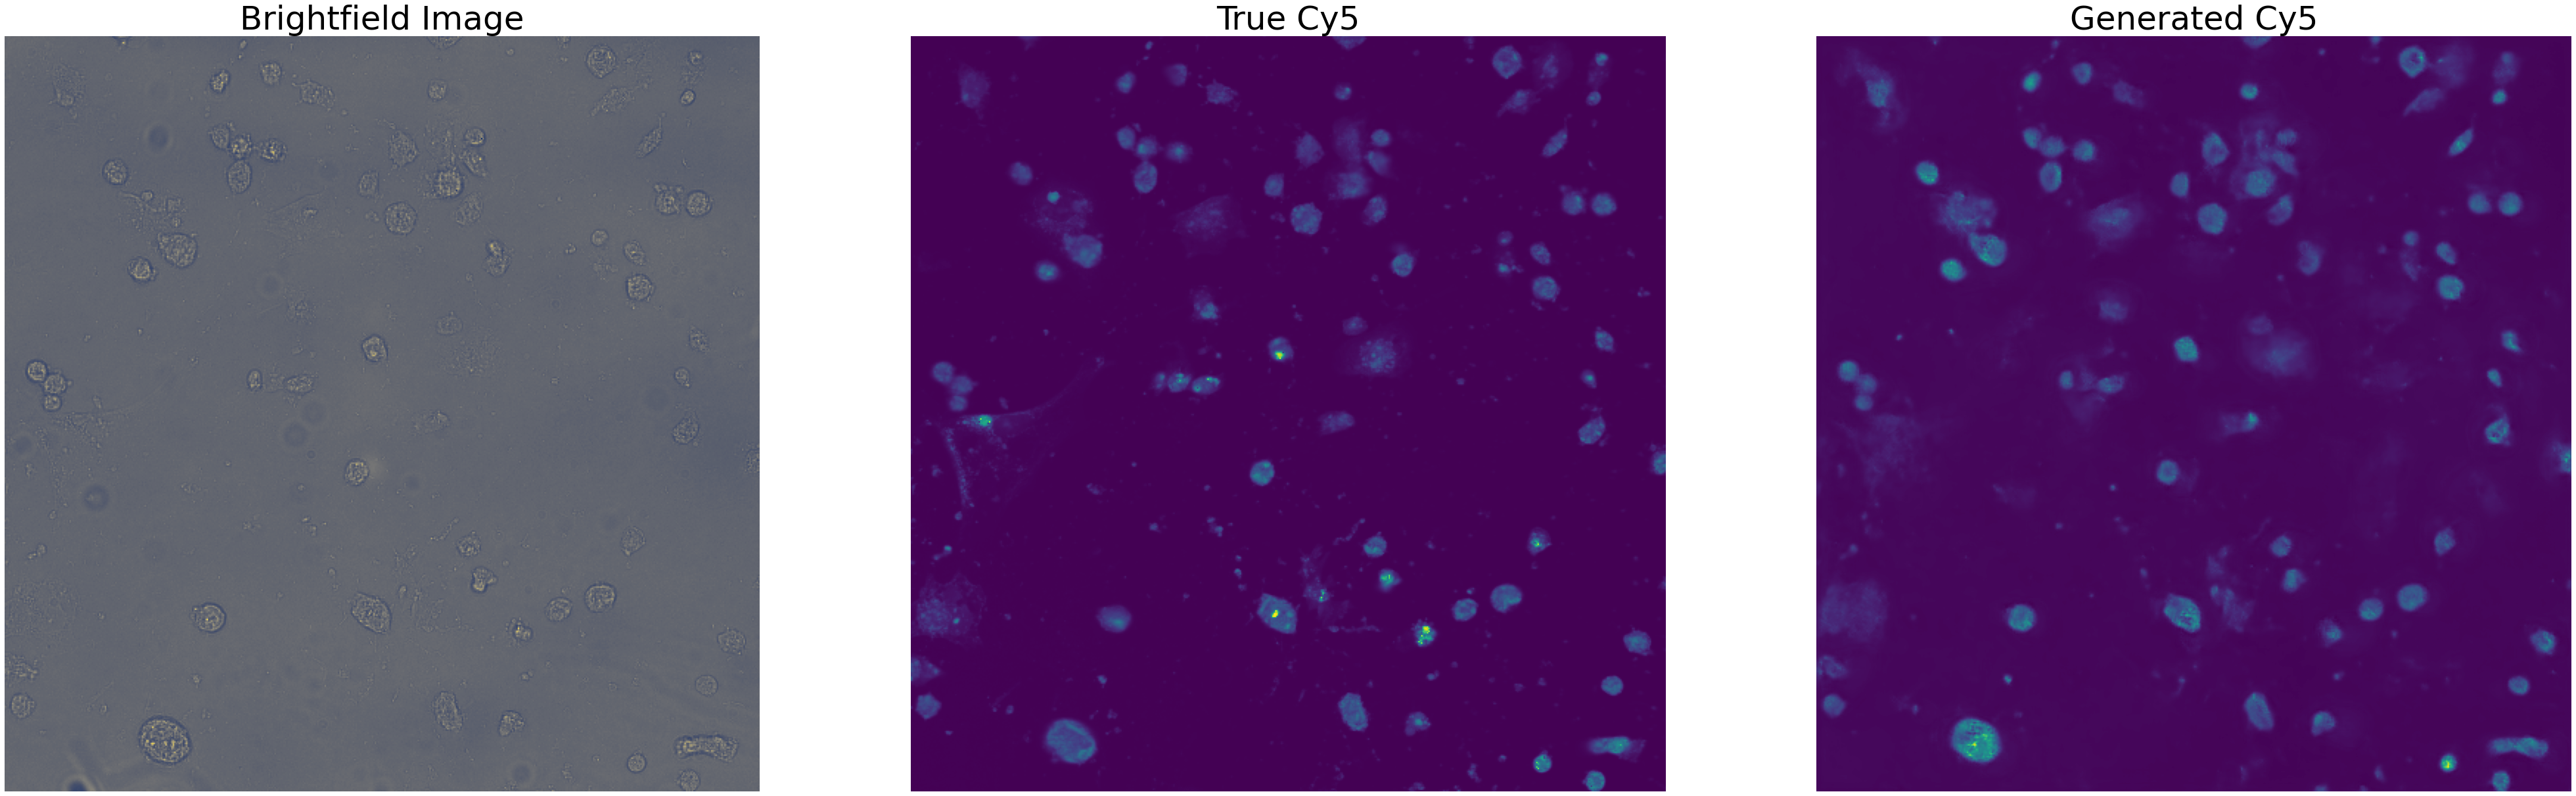

In [25]:
with torch.no_grad():
    inv_y = inv_normalize_label(y)
    fig, ax = plt.subplots(2,5,gridspec_kw={'width_ratios': [1, 1, 1,1,1]},figsize=(70, 25))
    #plt.tight_layout()
    #ax1 = plt.subplot2grid((2,5),(0,0),rowspan = 2)
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.title("Brightfield Image",fontsize=50)
    plt.imshow(to_image(10*inv_normalize_BF(x).type(torch.int16).squeeze(0)+10000),cmap = 'cividis')
    for i in range(1):
        plt.subplot(1,3,2)
        plt.axis('off')
        plt.title('True '+title[i],fontsize=50)
        plt.imshow(to_image(inv_y[i].type(torch.int16).squeeze(0)))
    for i in range(1):
        plt.subplot(1,3,3)
        plt.axis('off')
        plt.title('Generated '+title[i],fontsize=50)
        plt.imshow(to_image(inv_normalize_label(G(x.unsqueeze(0).cuda()).squeeze(0))[i].type(torch.int16)))
        
plt.savefig('plot')